# Fraud Detection

This notebook takes advantage of the power of SQL Server and RevoScaleR (Microsoft R Server). The tables are all stored in a SQL Server, and most of the computations are done by loading chunks of data in-memory instead of the whole dataset.

It does the following: 

 * **Step 0: Packages, Compute Contexts and Database Creation**
 * **Step 1: Creating the Tagged Data**
 * **Step 2: Splitting and Data Cleaning of the training set**
 * **Step 3: Feature Engineering on the training set**
 * **Step 4: Training, Preprocessing and Feature Engineering on the test set, Scoring and Evalutating the model**

## Step 0: Packages, Compute Contexts and Database Creation

#### In this step, we set up the connection string to access a SQL Server Database we create and load the necessary packages. 

In [3]:
# WARNING.
# We recommend not using Internet Explorer as it does not support plotting, and may crash your session.

In [4]:
# INPUT DATA SETS: point to the correct path.  
Untagged_Transactions <- "C:/dsvm/notebooks/untaggedTransactions.csv"
Account_Info <- "C:/dsvm/notebooks/accountInfo.csv"
Fraud_Transactions <- "C:/dsvm/notebooks/fraudTransactions.csv"

In [5]:
# Load packages.
library(RevoScaleR)
library("MicrosoftML")

In [10]:
# Creating the connection string. Specify:
## Database name. If it already exists, tables will be overwritten. If not, it will be created.
## Server name. If conecting remotely to the DSVM, the full DNS address should be used with the port number 1433 (which should be enabled) 

db_name <- "Fraud"
server <- "localhost"
user_id <- "XXXYOURSQLUSERID"
password <- "XXXYOUORSQLPW"

connection_string <- sprintf("Driver=SQL Server;Server=%s;Database=%s;UID=%s;PWD=%s", server, db_name, user_id, password)

print("Connection String Written.")

[1] "Connection String Written."


In [11]:
# Create the database if not already existing. 

## Open an Odbc connection with SQL Server master database only to create a new database with the rxExecuteSQLDDL function.
connection_string_master <- sprintf("Driver=SQL Server;Server=%s;Database=master;UID=%s;PWD=%s", server, user_id, password)
outOdbcDS_master <- RxOdbcData(table = "Default_Master", connectionString = connection_string_master)                         
rxOpen(outOdbcDS_master, "w")

## Create database if not already existing. 
query <- sprintf( "if not exists(SELECT * FROM sys.databases WHERE name = '%s') CREATE DATABASE %s;", db_name, db_name)
rxExecuteSQLDDL(outOdbcDS_master, sSQLString = query)

## Close Obdc connection to master database. 
rxClose(outOdbcDS_master)

print("Database created if not already existing.")

Warning message in rxOpen(outOdbcDS_master, "w"):
"Currently only mode ="r" (read-only) is supported."

[1] TRUE

[1] TRUE

Warning message in rxClose(outOdbcDS_master):
"The datasource is not open yet."

[1] TRUE

[1] "Database created if not already existing."


In [12]:
# Define SQL Compute Context.
sql <- RxInSqlServer(connectionString = connection_string)

# Open a connection with SQL Server to be able to write queries with the rxExecuteSQLDDL function in the new database.
outOdbcDS <- RxOdbcData(table = "Default", connectionString = connection_string)
rxOpen(outOdbcDS, "w")

Warning message in rxOpen(outOdbcDS, "w"):
"Currently only mode ="r" (read-only) is supported."

[1] TRUE

#### The function below can be used to get the top n rows of a table stored on SQL Server. 
#### You can execute this cell throughout your progress by removing the comment "#", and inputting:
#### - the table name.
#### - the number of rows you want to display.

In [13]:
display_head <- function(table_name, n_rows){
   table_sql <- RxSqlServerData(sqlQuery = sprintf("SELECT TOP(%s) * FROM %s", n_rows, table_name), connectionString = connection_string)
   table <- rxImport(table_sql)
   print(table)
}

# table_name <- "insert_table_name"
# n_rows <- 10
# display_head(table_name, n_rows)

## Step 1: Creating the Tagged Data

In this step, we:

**1.** Upload the 3 data sets Untagged_Transactions, Account_Info and Fraud_Transactions from disk to SQL Server

**2.** Create the transactionDateTime variable based on transactionDate and transactionTime.

**3.** Merge the two tables Untagged_Transaction ad Account_Info.

**4.** Remove duplicates from the 2 tables. 

**5.** Merge the 2 tables and create the label.

**Input:** 3 Data Tables: Untagged_Transactions, Account_Info and Fraud_Transactions.

**Output:** Tagged data.

In [14]:
# Set the compute context to Local. 
rxSetComputeContext('local')

In [16]:
# Upload the data set to SQL.

## Specify the desired column types. 
## Character and Factor are converted to varchar(255) in SQL Server. 
column_types_untagged <- c(transactionID = "character",
                           accountID = "character",
                           transactionAmountUSD = "character",
                           transactionAmount = "character",
                           transactionCurrencyCode = "character",
                           transactionCurrencyConversionRate = "character",
                           transactionDate = "character",
                           transactionTime = "character",
                           localHour = "character",
                           transactionScenario = "character",
                           transactionType = "character",
                           transactionMethod = "character",
                           transactionDeviceType = "character",
                           transactionDeviceId = "character",
                           transactionIPaddress = "character",
                           ipState = "character",
                           ipPostcode = "character",
                           ipCountryCode = "character",
                           isProxyIP = "character",
                           browserType = "character",
                           browserLanguage = "character",
                           paymentInstrumentType = "character",
                           cardType = "character",
                           cardNumberInputMethod = "character",
                           paymentInstrumentID = "character",
                           paymentBillingAddress = "character",
                           paymentBillingPostalCode = "character",
                           paymentBillingState = "character",
                           paymentBillingCountryCode = "character",
                           paymentBillingName = "character",
                           shippingAddress = "character",
                           shippingPostalCode = "character",
                           shippingCity = "character",
                           shippingState = "character",
                           shippingCountry = "character",
                           cvvVerifyResult = "character",
                           responseCode = "character",
                           digitalItemCount = "character",
                           physicalItemCount = "character",
                           purchaseProductType = "character")

column_types_account <- c(accountID = "character",
                          transactionDate = "character",
                          transactionTime = "character",  
                          accountOwnerName = "character",
                          accountAddress = "character",
                          accountPostalCode = "character",
                          accountCity = "character",
                          accountState = "character",
                          accountCountry = "character",
                          accountOpenDate = "character",
                          accountAge = "character",
                          isUserRegistered = "character",
                          paymentInstrumentAgeInAccount = "character",
                          numPaymentRejects1dPerUser = "character")

column_types_fraud <- c(transactionID = "character",
                        accountID = "character",
                        transactionAmount = "character",
                        transactionCurrencyCode = "character",
                        transactionDate = "character", 
                        transactionTime = "character",
                        localHour = "character",
                        transactionDeviceId = "character",
                        transactionIPaddress = "character")
  
## Point to the input data sets while specifying the classes.
Untagged_Transactions_text <- RxTextData(file = Untagged_Transactions, colClasses = column_types_untagged)
Account_Info_text <- RxTextData(file = Account_Info, colClasses = column_types_account)
Fraud_Transactions_text <- RxTextData(file = Fraud_Transactions, colClasses = column_types_fraud)

## Upload the data to SQL tables. 
## At the same time, we create transactionDateTime. This is done by:
### converting transactionTime into a 6 digit time.
### concatenating transactionDate and transactionTime.
### converting it to a DateTime "%Y%m%d %H%M%S" format. 

Untagged_Transactions_sql <- RxSqlServerData(table = "Untagged_Transactions", connectionString = connection_string)
Account_Info_sql <- RxSqlServerData(table = "Account_Info", connectionString = connection_string)
Fraud_Transactions_sql <- RxSqlServerData(table = "Fraud_Transactions", connectionString = connection_string)

rxDataStep(inData = Untagged_Transactions_text, outFile = Untagged_Transactions_sql, overwrite = TRUE, 
           transforms = list(
             transactionDateTime = as.character(as.POSIXct(paste(transactionDate, sprintf("%06d", as.numeric(transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT"))
           ))

rxDataStep(inData = Account_Info_text, outFile = Account_Info_sql, overwrite = TRUE, 
           transforms = list(
             recordDateTime = as.character(as.POSIXct(paste(transactionDate, sprintf("%06d", as.numeric(transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT"))
           ))

rxDataStep(inData = Fraud_Transactions_text, outFile = Fraud_Transactions_sql, overwrite = TRUE, 
           transforms = list(
             transactionDateTime = as.character(as.POSIXct(paste(transactionDate, sprintf("%06d", as.numeric(transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT"))
           ))

print("Data exported to SQL.")

Total Rows written: 100000, Total time: 5.859
Total Rows written: 200000, Total time: 13.019
Rows Read: 200000, Total Rows Processed: 200000, Total Chunk Time: 27.988 seconds 
Total Rows written: 100000, Total time: 3.867
Total Rows written: 199515, Total time: 7.095
Rows Read: 199515, Total Rows Processed: 199515, Total Chunk Time: 14.200 seconds 
Total Rows written: 8640, Total time: 0.257
Rows Read: 8640, Total Rows Processed: 8640, Total Chunk Time: 0.504 seconds 
[1] "Data exported to SQL."


In [17]:
# Set the compute context to SQL. 
rxSetComputeContext(sql)

In [18]:
# Convert transactionDateTime to a datetime format in SQL Server. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("ALTER TABLE Untagged_Transactions ALTER COLUMN transactionDateTime datetime;"
                                              , sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("ALTER TABLE Account_Info ALTER COLUMN recordDateTime datetime;"
                                              , sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("ALTER TABLE Fraud_Transactions ALTER COLUMN transactionDateTime datetime;"
                                              , sep=""))

print("transactionDateTime converted to a datetime type in SQL Server.")

[1] TRUE

[1] TRUE

[1] TRUE

[1] "transactionDateTime converted to a datetime type in SQL Server."


In [19]:
# Sort Account_Info in descending order of accountID, transactionDateTime. 
# Note: SQL queries are used here because the rxSort function is not available for SQL data sources.
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Account_Info_Sort;"
                                              , sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("SELECT * INTO Account_Info_Sort FROM Account_Info
                                              ORDER BY accountID, recordDateTime desc;"
                                              , sep=""))

print("Account_Info table sorted in ascending order of accountID, and descending order of recordDateTime.")

[1] TRUE

[1] TRUE

[1] "Account_Info table sorted in descending order of accountID, transactionDateTime."


In [20]:
# Inner join of the 2 tables Untagged_Transacations and Account_Info_Sort.
# Note: SQL queries are used here becasue the rxMerge function is not available for SQL data sources.
## the top 1 is the maximum transactionDateTime up to current transactionDateTime

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Untagged_Transactions_Account;"
                                              , sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "SELECT t1.*, t2.accountOwnerName, t2.accountAddress, t2.accountPostalCode, t2.accountCity, t2.accountState,
  t2.accountCountry, t2.accountOpenDate, t2.accountAge, t2.isUserRegistered, 
  t2.paymentInstrumentAgeInAccount, t2.numPaymentRejects1dPerUser
  INTO Untagged_Transactions_Account
  FROM 
  (SELECT * FROM Untagged_Transactions) AS t1
  OUTER APPLY
  (SELECT top 1 * FROM Account_Info_Sort AS t WHERE t.accountID = t1.accountID and t.recordDateTime <= t1.transactionDateTime) AS t2
  WHERE t1.accountID = t2.accountID;"
  , sep=""))


print("Merging of the two tables completed.")

[1] TRUE

[1] TRUE

[1] "Merging of the two tables completed."


In [21]:
# We remove duplicates based on keys: transactionID, accountID, transactionDateTime, transactionAmount.
## Sometimes an entire transaction might be divided into multiple sub-transactions, so we can have the same IDs and Time but different amounts. 
## Note that it will be done with SQL queries and not with rx functions because evaluating if a row is a duplicate would not be possible 
## if the data is loaded chunk by chunk.

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "WITH cte_1
  AS (SELECT ROW_NUMBER() OVER (PARTITION BY transactionID, accountID, transactionDateTime, transactionAmount ORDER BY transactionID ASC) RN 
  FROM Untagged_Transactions_Account)
  DELETE FROM cte_1
  WHERE  RN > 1;"
  , sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "WITH cte_2
  AS (SELECT ROW_NUMBER() OVER (PARTITION BY transactionID, accountID, transactionDateTime, transactionAmount ORDER BY transactionID ASC) RN 
  FROM Fraud_Transactions)
  DELETE FROM cte_2
  WHERE  RN > 1;"
  , sep=""))


print("Duplicates removed from Untagged_Transactions_Account and Fraud_Transactions.")

[1] TRUE

[1] TRUE

[1] "Duplicates removed from Untagged_Transactions_Account and Fraud_Transactions."


In [22]:
# We aggregate the Fraud table on the account level and create start and end date time.
# We then perform a left join with the Untagged_Transactions_Account table. 
# This gives us a table with all the previous data, in addition to the date time of the 1st and last transactions for the accounts 
# that were in the fraud table. 

Untagged_Fraud_Account_sql <- RxSqlServerData(sqlQuery = 
                                                "SELECT t1.*, t2.startDateNTime, t2.endDateNTime
                                                FROM Untagged_Transactions_Account AS t1
                                                LEFT JOIN
                                                (SELECT accountID, min(transactionDateTime) as startDateNTime, max(transactionDateTime) as endDateNTime 
                                                FROM Fraud_Transactions
                                                GROUP BY accountID) AS t2
                                                ON t1.accountID = t2.accountID",
                                              connectionString = connection_string)

# Output table pointer.
Tagged_sql <- RxSqlServerData(table = "Tagged", connectionString = connection_string)

# We create the label variable as follows:
## if accountID can't be found in the fraud dataset, tag it as 0: not fraudulent.
## if accountID is found in the fraud dataset and transactionDateTime is within the fraud time range, tag it as 1: fraud.
## if accountID is found in the fraud dataset but transactionDateTime is out of the fraud time range, tag it as 2: pre-fraud.

rxDataStep(inData = Untagged_Fraud_Account_sql, 
           outFile = Tagged_sql,
           overwrite = TRUE,
           rowsPerRead = 200000,
           transforms = list(
             label = ifelse(is.na(startDateNTime), 0, 
                            ifelse(transactionDateTime >= startDateNTime & transactionDateTime <= endDateNTime, 1, 2))
              ))


print("Tags Added to the Data.")

[1] "Tags Added to the Data."


## Step 2: Splitting and Data Cleaning of the training set

In this step, we:

**1.** Split the tagged data set into a Training and a Testing set. 

**2.** Clean the training set and perform some preprocessing.   

**Input:** Tagged data set.

**Output:** Training and Testing sets, and cleaned Training set Tagged_Training_Processed.  

In [23]:

# Split the Tagged data set into a Training and a Testing set.

## Create the Hash_Id table containing accountID hashed to 100 bins. 
## The advantage of using a hashing function for splitting is to:
## - ensure that the same accountID ends up in the same split.
## - permit repeatability of the experiment.  
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Hash_Id;", sep = ""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "SELECT accountID, ABS(CAST(CAST(HashBytes('MD5', accountID) AS VARBINARY(64)) AS BIGINT) % 100) AS hashCode  
  INTO Hash_Id
  FROM Tagged ;", sep = ""))

## Point to the training set. 
## At the same time, we remove:
## - variables not used in the next steps (intermediate variables, variables not needed for the training, variables with only missing values). 
## - observations with labels equal to 2 (pre-fraud).
## - observations where accountID, transactionID and transactionDateTime are missing. 
## - observations where the transaction amount in USD is negative. 

query_training <- "SELECT label, accountID, transactionID, transactionDateTime, isProxyIP, paymentInstrumentType, cardType, paymentBillingAddress,
                          paymentBillingPostalCode, paymentBillingCountryCode, paymentBillingName, accountAddress, accountPostalCode,  
                          accountCountry, accountOwnerName, shippingAddress, transactionCurrencyCode,localHour, ipState, ipPostCode,
                          ipCountryCode, browserLanguage, paymentBillingState, accountState, transactionAmountUSD, digitalItemCount, 
                          physicalItemCount, accountAge, paymentInstrumentAgeInAccount, numPaymentRejects1dPerUser, isUserRegistered,
                          transactionDate, transactionTime
                   FROM Tagged 
                   WHERE accountID IN (SELECT accountID from Hash_Id WHERE hashCode <= 70)
                   AND label != 2
                   AND accountID IS NOT NULL
                   AND transactionID IS NOT NULL 
                   AND transactionDateTime IS NOT NULL 
                   AND cast(transactionAmountUSD as float) >= 0"

Tagged_Training_sql <- RxSqlServerData(sqlQuery = query_training, connectionString = connection_string)

print("Training and testing sets created.")


[1] TRUE

[1] TRUE

[1] "Training and testing sets created."


In [24]:
# Clean and preprocess the training set.

clean_preprocess <- function(input_data_query, output_sql_name){
  
  # Detect variables with missing values. 
  # No missing values in accountID, transactionID and transactionDateTime since we already filtered out missing values in the query above. 
  # For rxSummary to give correct info on characters, stringsAsFactors = T should be used in the pointer to the SQL Tagged_Training table.
  Tagged_Data_sql_stringsfactors <- RxSqlServerData(sqlQuery = input_data_query, connectionString = connection_string, stringsAsFactors = T)
  var <- rxGetVarNames(Tagged_Data_sql_stringsfactors)
  formula <- as.formula(paste("~", paste(var, collapse = "+")))
  summary <- rxSummary(formula, Tagged_Data_sql_stringsfactors, byTerm = TRUE)
  variables_NA <- summary$sDataFrame[summary$sDataFrame$MissingObs > 0, 1]
  variables_NA <- variables_NA[!variables_NA %in% c("accountID", "transactionID", "transactionDateTime", "transactionDate", "transactionTime")]
  
  # If no missing values, we will only preprocess the data. Otherwise, we clean and preprocess. 
  if(length(variables_NA) == 0){
    print("No missing values: only preprocessing will be performed.")
  } else{ 
    print("Variables containing missing values are:")
    print(variables_NA)
  }
  
  # Function to replace missing values with 0. It will be wrapped into rxDataStep. 
  preprocessing <- function(data) {
    data <- data.frame(data, stringsAsFactors = F)
    
    # Replace missing values with 0 except for localHour with -99. 
    if(length(var_with_NA) > 0){
      for(i in 1:length(var_with_NA)){
        row_na <- which(is.na(data[, var_with_NA[i]]) == TRUE) 
        if(var_with_NA[i] == c("localHour")){
          data[row_na, var_with_NA[i]] <- "-99"
        } else{
          data[row_na, var_with_NA[i]] <- "0"
        }
      }
    }
    
    # Fix some data entries in isUserRegistered, which should be binary.  
    row_na <- which(data[, c("isUserRegistered")] %in% as.character(seq(1, 9)))
    data[row_na, c("isUserRegistered")] <- "0"
    
    # Convert a few variables to numeric, replacing non-numeric entries with 0. a few other variables to fix some data entries.  
    numeric_to_fix <- c("accountAge", "paymentInstrumentAgeInAccount", "numPaymentRejects1dPerUser", "transactionAmountUSD",
                        "digitalItemCount", "physicalItemCount")
    for(i in 1:length(numeric_to_fix)){
      data[, numeric_to_fix[i]] <- as.numeric(data[, numeric_to_fix[i]])
      row_na <- which(is.na(as.numeric(data[, numeric_to_fix[i]])) == TRUE)
      data[row_na, numeric_to_fix[i]] <- 0
    }
    return(data)  
  }
  
  # Input and Output pointers. 
  Input_sql <- RxSqlServerData(sqlQuery = input_data_query, connectionString = connection_string)
  Output_sql <- RxSqlServerData(table =  output_sql_name, connectionString = connection_string)
    
  # We drop the output if it already exists as a view in case the SQL SP was executed in the same database before. 
  rxExecuteSQLDDL(outOdbcDS, sSQLString = sprintf("IF OBJECT_ID ('%s', 'V') IS NOT NULL DROP VIEW %s ;", 
                                                  output_sql_name, output_sql_name))
  
  # Perform the data cleaning with rxDataStep. 
  ## To preserve the type of transactionDateTime, we recreate it.
  rxDataStep(inData = Input_sql, 
             outFile = Output_sql, 
             overwrite = T, 
             rowsPerRead = 200000,
             transformFunc = preprocessing,
             transformObjects = list(var_with_NA = variables_NA),
             transforms = list(
               transactionDateTime = as.character(as.POSIXct(paste(transactionDate, sprintf("%06d", as.numeric(transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT"))
             ))

}

# Apply the preprocessing and cleaning to the training set. 
clean_preprocess(input_data_query = query_training, 
                 output_sql_name = "Tagged_Training_Processed")

print("Training set cleaned and preprocessed.")


[1] "Variables containing missing values are:"
 [1] "isProxyIP"                     "cardType"                     
 [3] "paymentBillingAddress"         "paymentBillingPostalCode"     
 [5] "paymentBillingCountryCode"     "paymentBillingName"           
 [7] "accountAddress"                "accountPostalCode"            
 [9] "accountCountry"                "accountOwnerName"             
[11] "shippingAddress"               "localHour"                    
[13] "ipState"                       "ipPostCode"                   
[15] "ipCountryCode"                 "paymentBillingState"          
[17] "accountState"                  "accountAge"                   
[19] "paymentInstrumentAgeInAccount" "numPaymentRejects1dPerUser"   
[1] "Training set cleaned and preprocessed."


## Step 3: Feature Engineering on the training set

In this step, we:

**1.** Create the Risk tables. 

**2.** Assign risk values to the variables in the training set. 

**3.** Create flags for mismatches between addresses, and flags for high amount transactions. 

**4.** Create aggregates corresponding to the number and amount of transactions in the past day and 30 days for every transaction per accountID.

**5.** Fix variable types for training. 

**Input:** Cleaned training set Tagged_Training_Processed.

**Output:** Training set with new features Tagged_Training_Preprocessed_Features.

In [25]:
# Function that creates and uploads to SQL a Risk table for 1 variable. 
create_risk_table <- function(variable_name, data, smooth1, smooth2){
  
  # Compute the number of frauds and non-frauds for each level of the variable. 
  formula <- as.formula(paste(" ~ F(label) :", variable_name))
  Counts_table <- rxCrossTabs(formula = formula, data = data)$counts[[1]]
  Counts <- data.frame(x = colnames(Counts_table), fraudCount = Counts_table["1", ], nonFraudCount = Counts_table["0",], row.names = NULL)
  colnames(Counts)[1] <- variable_name
  
  # Compute the smoothed fraud rate of each level of the variable. 
  Odds <- (Counts$fraudCount + smooth1)/(Counts$nonFraudCount + Counts$fraudCount + smooth2)
  # Compute the log of the smoothed odds ratio.
  Risk <- log(Odds/(1-Odds))
  
  # Create the Risk table.
  Risk_df <- as.data.frame(cbind(as.character(Counts[, variable_name]), Risk))
  colnames(Risk_df) <- c(variable_name, "risk")
  
  # Export it to SQL: Output table pointer for the Risk Table of the specific variable. 
  rxSetComputeContext('local')
  table_name <- paste("Risk_", toupper(substring(variable_name, 1, 1)), substring(variable_name, 2), sep = "", collapse = " ")
  Risk_sql <- RxSqlServerData(table = table_name, connectionString = connection_string)
  rxDataStep(inData = Risk_df, outFile = Risk_sql, overwrite = TRUE)
  
  # Set back the compute context to sql.
  rxSetComputeContext(sql)
  
}

# Variables for which we create Risk Tables. 
risk_vars <- c("transactionCurrencyCode", "localHour", "ipState", "ipPostCode","ipCountryCode", "browserLanguage",
               "accountPostalCode", "accountState", "accountCountry", "paymentBillingPostalCode", "paymentBillingState",
               "paymentBillingCountryCode")

# Pointer to the preprocessed training set with stringsAsFactors = TRUE for correct summary computations. 
Train_sqlstringsfactors <- RxSqlServerData(table = "Tagged_Training_Processed", connectionString = connection_string, stringsAsFactors = T)

# We apply create_risk_table sequentially over the variables in risk_vars. 
for(variable_name in risk_vars){
  create_risk_table(variable_name = variable_name, data = Train_sqlstringsfactors, smooth1 = 10, smooth2 = 100)
}

print("Risk Tables created using the Training set.")


Rows Read: 66, Total Rows Processed: 66
Total Rows written: 66, Total time: 0.003
, Total Chunk Time: 0.027 seconds 
Rows Read: 26, Total Rows Processed: 26
Total Rows written: 26, Total time: 0.003
, Total Chunk Time: 0.030 seconds 
Rows Read: 1045, Total Rows Processed: 1045
Total Rows written: 1045, Total time: 0.025
, Total Chunk Time: 0.055 seconds 
Rows Read: 9510, Total Rows Processed: 9510
Total Rows written: 9510, Total time: 0.212
, Total Chunk Time: 0.255 seconds 
Rows Read: 186, Total Rows Processed: 186
Total Rows written: 186, Total time: 0.005
, Total Chunk Time: 0.031 seconds 
Rows Read: 191, Total Rows Processed: 191
Total Rows written: 191, Total time: 0.005
, Total Chunk Time: 0.033 seconds 
Rows Read: 46410, Total Rows Processed: 46410
Total Rows written: 46410, Total time: 1.026
, Total Chunk Time: 1.127 seconds 
Rows Read: 1154, Total Rows Processed: 1154
Total Rows written: 1154, Total time: 0.027
, Total Chunk Time: 0.056 seconds 
Rows Read: 185, Total Rows Proc

In [26]:
# Assign risk values to the variables, and create address mismatch and high amount flags.

assign_risk_and_flags <- function(input_sql_name, output_sql_name){
  
  # Function to assign the risk values. It will be wrapped into rxDataStep. 
  assign_risk <- function(data) {
    data <- data.frame(data, stringsAsFactors = F)
    
    for(name in  risk_variables){
      # Import the Risk table from SQL Server. 
      table_name <- paste("Risk_", toupper(substring(name, 1, 1)), substring(name, 2), sep = "", collapse = " ")
      Risk_sql <- RxSqlServerData(table = table_name, connectionString = connection_string)
      Risk_df <- rxImport(Risk_sql)
      
      # Perform a left outer join with the Risk table. This will assign the risk value to every level of the variable. 
      data <- base::merge(data, Risk_df, by = name, all.x = TRUE)
      new_name <- paste(name, "Risk", sep ="")
      colnames(data)[ncol(data)] <- new_name
      
      # If a new level was found in the data, the assigned risk is NULL. We convert it to 0. 
      row_na <- which(is.na(data[, new_name]) == TRUE) 
      data[row_na, new_name] <- 0
      
    }  
    return(data)  
  }
  
  
  # Input and Output pointers. 
  Input_sql <- RxSqlServerData(table = input_sql_name, connectionString = connection_string)
  Output_sql <- RxSqlServerData(table = output_sql_name, connectionString = connection_string)
    
  # We drop the output if it already exists as a view in case the SQL SP was executed in the same database before. 
  rxExecuteSQLDDL(outOdbcDS, sSQLString = sprintf("IF OBJECT_ID ('%s', 'V') IS NOT NULL DROP VIEW %s ;", 
                                                  output_sql_name, output_sql_name))
  
  # Create buckets for various numeric variables with the function Bucketize. 
  # At the same time, we create other variables:
  ## isHighAmount: flag for transactions of a high amount. 
  ## various flags showing if there is a mismatch in the addresses variables.
  rxDataStep(inData = Input_sql,
             outFile = Output_sql, 
             overwrite = TRUE, 
             rowsPerRead = 200000,
             transformFunc = assign_risk,
             transformObjects =  list(risk_variables = risk_vars, connection_string = connection_string),
             transforms = list(
               isHighAmount = ifelse(transactionAmountUSD > 150, "1", "0"),
               acctBillingAddressMismatchFlag = ifelse(paymentBillingAddress == accountAddress, "0", "1"),
               acctBillingPostalCodeMismatchFlag = ifelse(paymentBillingPostalCode == accountPostalCode, "0", "1"),
               acctBillingCountryMismatchFlag = ifelse(paymentBillingCountryCode == accountCountry, "0", "1"),
               acctBillingNameMismatchFlag= ifelse(paymentBillingName == accountOwnerName, "0", "1"),
               acctShippingAddressMismatchFlag = ifelse(shippingAddress == accountAddress, "0", "1"),
               shippingBillingAddressMismatchFlag = ifelse(shippingAddress == paymentBillingAddress, "0", "1")
             ))
}

# Apply the assign_risk_and_flags function. 
assign_risk_and_flags(input_sql_name = "Tagged_Training_Processed",
                      output_sql_name = "Tagged_Training_Processed_Features1")

print("Risk values assigned to the variables, and address mismatch and high amount flags created.")


[1] "Risk values assigned to the variables, and address mismatch and high amount flags created."


In [27]:
# Compute the number of transactions and their amounts in the past day and 30 days for every transaction per accountID.

compute_aggregates <- function(input_sql_name, output_sql_name){
  
  # We drop the output if it already exists as a view in case the SQL SP was executed in the same database before. 
  rxExecuteSQLDDL(outOdbcDS, sSQLString = sprintf("IF OBJECT_ID ('%s', 'V') IS NOT NULL DROP VIEW %s ;", 
                                                  output_sql_name, output_sql_name))  
    
  # Import the data set and fix the datetime type. 
  rxSetComputeContext('local')
  
  Input_sql <- RxSqlServerData(table = input_sql_name, connectionString = connection_string)
  data = rxImport(Input_sql)
  data$transactionDateTime <- as.POSIXct(paste(data$transactionDate, sprintf("%06d", as.numeric(data$transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT")
  
  # Function that computes the aggregates for a given accountID. 
  
  aggregates_account_level <- function(dt){
    if(nrow(dt) == 1){ #if there is only 1 transaction in that account, no aggregation. 
      return(NULL)
      
    } else{ 
      # Perform a cross-apply and filter: for each transactionID, z has data about the other transactionID that occured in the past 30 days.
      z = merge(x = dt, y = dt[, c("transactionID", "transactionDateTime", "transactionAmountUSD")], by = NULL)
      z = z[z$transactionID.x != z$transactionID.y & difftime(z$transactionDateTime.x , z$transactionDateTime.y, units = "days")  > 0 & difftime(z$transactionDateTime.x , z$transactionDateTime.y, units = "days") < 30,]
      
      # Keep the transactionIDs that occurred in the past 1 day and 30 days respectively. 
      z1day = z[difftime(z$transactionDateTime.x , z$transactionDateTime.y, units = "days") <= 1, ]
      z30day = z[difftime(z$transactionDateTime.x , z$transactionDateTime.y, units = "days") <= 30, ]
      
      # Compute the number of rows (sumPurchaseCount1dPerUser) and the total amount spent in the past day (sumPurchaseAmount1dPerUser). 
      if(nrow(z30day) == 0){
        return(NULL)
      } else{
        aggsum30day <- aggregate(z30day$transactionAmountUSD.y, by = list(z30day$transactionID.x), FUN = sum)
        colnames(aggsum30day) <- c("transactionID", "sumPurchaseAmount30dPerUser")
        aggcount30day <- aggregate(z30day$transactionAmountUSD.y, by = list(z30day$transactionID.x), FUN = NROW)
        colnames(aggcount30day) <- c("transactionID", "sumPurchaseCount30dPerUser")
        agg30day <- merge(x = aggsum30day, y = aggcount30day  , by = "transactionID")
      }
      
      # Compute the number of rows (sumPurchaseCount30dPerUser) and the total amount spent in the past 30 days (sumPurchaseAmount30dPerUser). 
      if(nrow(z1day) == 0){
        agg30day$sumPurchaseAmount1dPerUser <- 0
        agg30day$sumPurchaseCount1dPerUser <- 0
        return(agg30day)
      } else{
        aggsum1day <- aggregate(z1day$transactionAmountUSD.y, by = list(z1day$transactionID.x), FUN = sum)
        colnames(aggsum1day) <- c("transactionID", "sumPurchaseAmount1dPerUser")
        aggcount1day <- aggregate(z1day$transactionAmountUSD.y, by = list(z1day$transactionID.x), FUN = NROW)
        colnames(aggcount1day) <- c("transactionID", "sumPurchaseCount1dPerUser")
        agg1day <- merge(x = aggsum1day, y = aggcount1day  , by = "transactionID")
      }
      
      # Return the 4 new variables for each transactionID that had other transactions in the past 30 days. 
      agg <- merge(x = agg1day, y = agg30day  , by = "transactionID", all = TRUE)
      return(agg)
    }
  }
  
  # Split the data set by accountID. 
  Splits <- split(data, f = data$accountID)
  
  # Compute the aggregations for each accountID with the user defined function aggregates_account_level. 
  Aggregations_list <- lapply(X = Splits, FUN = aggregates_account_level)
  
  # Bind the results into 1 data frame. 
  Aggregations_df <- do.call("rbind", Aggregations_list)
  
  # Add the new variables to the initial data with a left outer join.  
  Output_df <- merge(x = data, y = Aggregations_df, by = "transactionID", all.x = TRUE)
  
  # The transactions that had no other transactions in the 30 day time frame have missing values. We convert them to 0.
  for(new_name in c("sumPurchaseCount1dPerUser", "sumPurchaseCount30dPerUser", "sumPurchaseAmount1dPerUser", "sumPurchaseAmount30dPerUser")){
    row_na <- which(is.na(Output_df[, new_name]) == TRUE) 
    Output_df[row_na, new_name] <- 0
  }

  # Write the result back to SQL. 
  Output_sql <- RxSqlServerData(table = output_sql_name, connectionString = connection_string)
  
  rxDataStep(inData = Output_df,
             outFile = Output_sql,
             overwrite = TRUE)
  
  # Set the compute context back to sql. 
  rxSetComputeContext(sql)
  
  # Convert the label to character format in SQL Server. 
  query <- sprintf( "ALTER TABLE %s ALTER COLUMN label char(1);", output_sql_name)
  rxExecuteSQLDDL(outOdbcDS, sSQLString = query)
  
}

# Apply the function. 
input_sql_name <- "Tagged_Training_Processed_Features1"
output_sql_name <- "Tagged_Training_Processed_Features"

compute_aggregates(input_sql_name, 
                   output_sql_name)

print("Number of transactions and their amounts in the past day and 30 days for every transaction per accountID computed.")


Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 4.901 seconds
Rows Read: 50000, Total Rows Processed: 100000, Total Chunk Time: 5.078 seconds
Rows Read: 41734, Total Rows Processed: 141734, Total Chunk Time: 4.495 seconds 
Rows Read: 141734, Total Rows Processed: 141734
Total Rows written: 100000, Total time: 8.565
Total Rows written: 141734, Total time: 11.965
, Total Chunk Time: 12.173 seconds 


[1] TRUE

[1] "Number of transactions and their amounts in the past day and 30 days for every transaction per accountID computed."


In [28]:
# Get the column information for training and testing. 

## Point to the training set with new features with stringsAsFactors = TRUE to get the column information. 
Tagged_Training_Processed_Features_sql <- RxSqlServerData(table = "Tagged_Training_Processed_Features", 
                                                          connectionString = connection_string,
                                                          stringsAsFactors = TRUE)

## Save the column information.  
column_info <- rxCreateColInfo(Tagged_Training_Processed_Features_sql, sortLevels = TRUE)

column_info$accountID <- NULL
column_info$transactionDate <- NULL
column_info$transactionTime <- NULL
column_info$transactionDateTime <- NULL

## Create a pointer to the training set, ready for training. 
Tagged_Training_Processed_Features_sql <- RxSqlServerData(table = "Tagged_Training_Processed_Features", 
                                                          connectionString = connection_string,
                                                          colInfo = column_info)

print("Variables information saved.")


[1] "Variables information saved."


## Step 4: Training, Preprocessing and Feature Engineering on the test set, Scoring and Evalutating the model

In this step we:

**1.** Train a boosted tree classification model on the training set and save it to SQL. 
 
**2.** Preprocess and perform feature engineering for the testing set. 

**3.** Score the GBT on the test set.

**4.** Evaluate the tested model: ROC, AUC, and fraud level account metrics. 

**Input:** Featurized training set Tagged_Training_Processed_Features.

**Output:** GBT Model, Predictions and Evaluation Metrics. 

In [29]:
# Write the formula after removing variables not used in the modeling.
## We remove the id variables, the dates, and the variables for which we computed the risk values. 
variables_all <- rxGetVarNames(Tagged_Training_Processed_Features_sql)

risk_vars <- c("transactionCurrencyCode", "localHour", "ipState", "ipPostCode","ipCountryCode", "browserLanguage",
               "accountPostalCode", "accountState", "accountCountry", "paymentBillingPostalCode", "paymentBillingState",
               "paymentBillingCountryCode")

address_vars <- c("paymentBillingAddress", "accountAddress", "shippingAddress", "paymentBillingName", "accountOwnerName")

variables_to_remove <- c("label", "accountID", "transactionID", "transactionDateTime", "transactionDate", "transactionTime", risk_vars, address_vars)
training_variables <- variables_all[!(variables_all %in% c("label", variables_to_remove))]
formula <- as.formula(paste("label ~", paste(training_variables, collapse = "+")))

print("Formula written.")

[1] "Formula written."


In [30]:
# Train the GBT Boosted Trees model.
## The unbalancedSets = TRUE argument helps deal with the class imbalance between fraud and non-fraud observations.
library(MicrosoftML)
boosted_fit <- rxFastTrees(formula = formula,
                           data = Tagged_Training_Processed_Features_sql,
                           type = c("binary"),
                           numTrees = 100,
                           learningRate = 0.2,
                           splitFraction = 5/24,
                           featureFraction = 1,
                           minSplit = 10,
                           unbalancedSets = TRUE,
                           randomSeed = 5)	

# The standard RevoScaleR rxBTrees function can also be used.
#boosted_fit <- rxBTrees(formula = formula,
#                        data = Tagged_Training_Processed_Features_sql,
#                        learningRate = 0.2,
#                        minSplit = 10,
#                        minBucket = 10,
#                        nTree = 100,
#                        seed = 5,
#                        lossFunction = "bernoulli")

print("Training GBT done.")

[1] "Training GBT done."


In [31]:
# Save the fitted model to SQL Server. Compute Context is set to local. 
rxSetComputeContext('local')

## Open an Odbc connection with SQL Server.
OdbcModel <- RxOdbcData(table = "Trained_Model", connectionString = connection_string)
rxOpen(OdbcModel, "w")

## Drop the Model table if it exists. 
if(rxSqlServerTableExists(OdbcModel@table, OdbcModel@connectionString)) {
  rxSqlServerDropTable(OdbcModel@table, OdbcModel@connectionString)
}

## Create an empty Model table. 
rxExecuteSQLDDL(OdbcModel, 
                sSQLString = paste(" CREATE TABLE [", OdbcModel@table, "] (",
                                   "     [id] varchar(200) not null, ",
                                   "     [value] varbinary(max), ",
                                   "     constraint unique_id3 unique (id))",
                                   sep = "")
)

## Write the model to SQL. 
rxWriteObject(OdbcModel, "Gradient Boosted Tree", boosted_fit)

# Close the Obdc connection used. 
rxClose(OdbcModel)

# Set the compute context back to SQL. 
rxSetComputeContext(sql)

print("Model uploaded to SQL.")

Warning message in rxOpen(OdbcModel, "w"):
"Currently only mode ="r" (read-only) is supported."

[1] TRUE

[1] TRUE

[1] TRUE

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.186
, Total Chunk Time: 0.292 seconds 


Warning message in rxClose(OdbcModel):
"The datasource is not open yet."

[1] TRUE

[1] "Model uploaded to SQL."


In [32]:
# Preprocess and perform feature engineering on the testing set, by calling previously defined functions. 

## Point to the testing set.
query_testing <- "SELECT label, accountID, transactionID, transactionDateTime, isProxyIP, paymentInstrumentType, cardType, paymentBillingAddress,
                         paymentBillingPostalCode, paymentBillingCountryCode, paymentBillingName, accountAddress, accountPostalCode,  
                         accountCountry, accountOwnerName, shippingAddress, transactionCurrencyCode,localHour, ipState, ipPostCode,
                         ipCountryCode, browserLanguage, paymentBillingState, accountState, transactionAmountUSD, digitalItemCount, 
                         physicalItemCount, accountAge, paymentInstrumentAgeInAccount, numPaymentRejects1dPerUser, isUserRegistered,
                         transactionDate, transactionTime
                  FROM Tagged 
                  WHERE accountID IN (SELECT accountID from Hash_Id WHERE hashCode > 70)
                  AND label != 2
                  AND accountID IS NOT NULL
                  AND transactionID IS NOT NULL 
                  AND transactionDateTime IS NOT NULL 
                  AND cast(transactionAmountUSD as float) >= 0"

## Apply the preprocessing and cleaning ot the training set. 
clean_preprocess(input_data_query = query_testing, 
                 output_sql_name = "Tagged_Testing_Processed")

## Apply the feature engineering on the testing set. 
assign_risk_and_flags(input_sql_name = "Tagged_Testing_Processed",
                      output_sql_name = "Tagged_Testing_Processed_Features1")

compute_aggregates(input_sql_name = "Tagged_Testing_Processed_Features1", 
                   output_sql_name = "Tagged_Testing_Processed_Features")


# Create a pointer to the testing set. 
Tagged_Testing_Processed_Features_sql <- RxSqlServerData(table = "Tagged_Testing_Processed_Features",
                                                          connectionString = connection_string,
                                                          colInfo = column_info)

print("Testing set preprocessed, and features added.")

[1] "Variables containing missing values are:"
 [1] "isProxyIP"                  "cardType"                  
 [3] "paymentBillingAddress"      "paymentBillingPostalCode"  
 [5] "paymentBillingCountryCode"  "paymentBillingName"        
 [7] "accountAddress"             "accountPostalCode"         
 [9] "accountCountry"             "accountOwnerName"          
[11] "shippingAddress"            "localHour"                 
[13] "ipState"                    "ipPostCode"                
[15] "ipCountryCode"              "paymentBillingState"       
[17] "accountState"               "accountAge"                
[19] "numPaymentRejects1dPerUser"
Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 4.773 seconds
Rows Read: 7761, Total Rows Processed: 57761, Total Chunk Time: 0.837 seconds 
Rows Read: 57761, Total Rows Processed: 57761
Total Rows written: 57761, Total time: 4.917
, Total Chunk Time: 5.021 seconds 


[1] TRUE

[1] "Testing set preprocessed, and features added."


In [33]:
# GBT Scoring

# Pointer to the SQL table where predictions will be written. 
Predict_Score1_sql <- RxSqlServerData(table = "Predict_Score1", connectionString = connection_string)

rxPredict(modelObject = boosted_fit,
          data = Tagged_Testing_Processed_Features_sql,
          outData = Predict_Score1_sql,
          overwrite = T,
          extraVarsToWrite = c("accountID", "transactionID", "transactionDate", "transactionTime", "transactionAmountUSD", "label"))


# To preserve the type of transactionDateTime, we recreate it.
# We also drop some variables. 
Predict_Score_sql <- RxSqlServerData(table = "Predict_Score", connectionString = connection_string)
rxDataStep(inData = Predict_Score1_sql, 
           outFile = Predict_Score_sql, 
           overwrite = T, 
           rowsPerRead = 200000,
           transforms = list(
             transactionDateTime = as.character(as.POSIXct(paste(transactionDate, sprintf("%06d", as.numeric(transactionTime)), sep=""), format = "%Y%m%d %H%M%S", tz = "GMT")),
             transactionDate = NULL, 
             transactionTime = NULL,
             PredictedLabel = NULL, 
             Score.1 = NULL,
             labelProb = Probability.1, 
             Probability.1 = NULL
           ))

print("Scoring done.")

[1] "Scoring done."


In [34]:
# Evaluation. 

# Set the compute context to local. 
rxSetComputeContext('local')

# Import the prediction table and convert label to numeric for correct evaluation. 
# We sort the predictions data in account_date_time order for the account level evaluation.
Predictions_sql <- RxSqlServerData(sqlQuery = "SELECT accountID, transactionDateTime, transactionAmountUSD, label, labelProb
                                   FROM Predict_Score
                                   ORDER BY accountID, transactionDateTime",
                                   connectionString = connection_string)

# Import the prediction table and convert label to numeric for correct evaluation. 
Predictions <- rxImport(Predictions_sql)
Predictions$label <- as.numeric(as.character(Predictions$label))
    
print("Predictions imported.")

Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 0.429 seconds
Rows Read: 7761, Total Rows Processed: 57761, Total Chunk Time: 0.074 seconds 
[1] "Predictions imported."


[1] "AUC = 0.604614520877891"


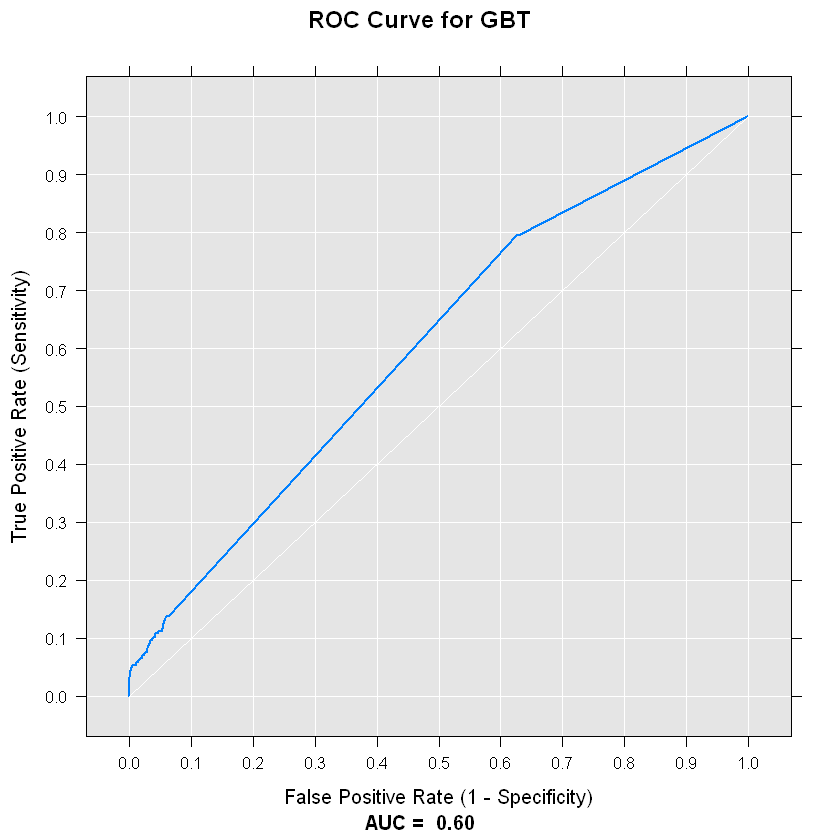

In [35]:
# Plot the ROC and compute the AUC. 
ROC <- rxRoc(actualVarName = "label", predVarNames = "labelProb", data = Predictions, numBreaks = 1000)
AUC <- rxAuc(ROC)
plot(ROC, title = "ROC Curve for GBT")

print(sprintf("AUC = %s", AUC))


In [38]:
## FRAUD ACCOUNT LEVEL METRICS: Implement account-level performance metrics and transaction-level metrics.
# ADR -- Fraud account detection rate
# VDR -- Value detection rate. The percentage of values saved.
# AFPR -- Account-level false positive ratio.
# ROC  -- Transaction-level ROC 
# $ROC -- Dollar weighted ROC
# TFPR -- Transaction level false positive ratio.

# sampling rate are taken into consideration to derive performance on original unsampled dataset.
# Variable contactPeriod is in the unit of days, indicating the lag before a customer is contacted again. 
# to verify high-score transactions are legitimate. 

scr2stat <- function(data, contactPeriod, sampleRateNF, sampleRateFrd)
{
  #scr quantization/binning into 1000 equal bins
  
  #account level score is the maximum of trans scores of that account
  #all transactions after the first fraud transaction detected are value savings
  #input score file needs to be acct-date-time sorted   
  
  nRows <- nrow(data)
  nBins <- 1000
  
  #1. Calculate the perf stats by score band.  
  prev_acct <- data$accountID[1]
  prev_score <- 0
  is_frd_acct <- 0
  max_scr <- 0
  
  scr_hash <- matrix(0, nBins, 10)
  
  f_scr_rec <- vector("numeric", nBins)
  # nf_scr_rec <- matrix(0, nBins, 2)  #count, datetime
  nf_scr_rec_count <- vector("numeric", nBins)
  nf_scr_rec_time <- vector("numeric", nBins)
  
  for (r in 1:nRows){
    acct <- as.character(data$accountID[r])
    dolamt <- data$transactionAmountUSD[r]
    label <- data$label[r]
    score <- data$labelProb[r]
    datetime <- data$transactionDateTime[r]
    
    if(score == 0){ 
      score <- score + 0.00001
      print ("The following account has zero score!")
      print (paste(acct, dolamt, datetime,sep = " "))
    }
    
    if (acct != prev_acct){
      scr_bin <- ceiling(max_scr*nBins)
      
      if (is_frd_acct){
        scr_hash[, 5] <- scr_hash[, 5] + f_scr_rec   #vdr
        scr_hash[scr_bin, 1] <- scr_hash[scr_bin, 1] + 1   #adr
      } else{
        scr_hash[,6] <- scr_hash[, 6] + as.numeric(nf_scr_rec_count)  #FP with contact period, a FP could be considered as multiple
        scr_hash[scr_bin, 2] <- scr_hash[scr_bin, 2] + 1   #a FP account considered one acct  
      }
      
      f_scr_rec <- vector("numeric", nBins)
      
      nf_scr_rec_count <- vector("numeric", nBins)
      nf_scr_rec_time <- vector("numeric", nBins)
      
      is_frd_acct <- 0
      total_nf_dol <- 0
      total_frd_dol <- 0
      max_scr <- 0
    }
    
    if (score > max_scr) {
      max_scr <- score
    }
    
    # Find out the bin the current account falls in. 
    tran_scr_bin <- ceiling(score*nBins)
    
    
    # Dollar weighted ROC and regular ROC.
    if(label == 1){
      scr_hash[tran_scr_bin, 3] <- scr_hash[tran_scr_bin, 3] + dolamt
      scr_hash[tran_scr_bin, 7] <- scr_hash[tran_scr_bin, 7] + 1
      is_frd_acct = 1
    } else{
      scr_hash[tran_scr_bin, 4] <- scr_hash[tran_scr_bin, 4] + dolamt
      scr_hash[tran_scr_bin, 8] <- scr_hash[tran_scr_bin, 8] + 1 
    }
    
    # ADR/VDR
    if(label == 1){
      # ADR
      f_scr_rec[tran_scr_bin] <- 1
      
      # VDR
      # If a higher score appeared before the current score, then this is also savings for the higher score.
      # Once a fraud transaction is discovered, all subsequent approved transactons are savings.
      for(i in  1: ceiling(max_scr*nBins)){
        f_scr_rec[i] <- f_scr_rec[i] + dolamt
      }
    } else { 
      # False Positive Accounts (FP) with recontact period.
      # Check if there is any earlier dates for the same or lower score.
      # Update the count and dates when within recontact period.
      
      #for(i in  1: floor(max_scr*nBins))
      for(i in  1: tran_scr_bin)
      {
        prev_time <- nf_scr_rec_time[i]
        #print(paste(i, tran_scr_bin, sep=" "))
        #print(paste(acct, datetime, sep=" "))
        #print(prev_time)
        if(prev_time > 0){
          timeDiff <- difftime(strptime(datetime,"%Y-%m-%d %H:%M:%S"), strptime(prev_time, "%Y-%m-%d %H:%M:%S"), units = "days") 
          if(timeDiff >= contactPeriod){
            nf_scr_rec_count[i] <- nf_scr_rec_count[i] + 1
            nf_scr_rec_time[i] <- datetime
          }
        } else{
          nf_scr_rec_count[i] <- nf_scr_rec_count[i] + 1
          nf_scr_rec_time[i] <- datetime
        }
      }
    } 
    prev_acct <- acct;
    
  }
  #1 -- #Frd Acct
  #2 -- #NF  Acct with infinite recontact period
  #3 -- $Frd Tran
  #4 -- $NF  Tran
  #5 -- $Frd Saving
  #6 -- #NF Acct with finite recontact period
  #7 -- #Frd Tran
  #8 -- #NF Tran
  #9 -- AFPR
  #10 --TFPR
  
  #2. Calculate the cumulative perf counts.
  
  # 5, 6 already in cumulative during previous calculation.
  for (i in (nBins-1):1){
    for(j in c(1:4,7:8)){
      scr_hash[i, j] <- scr_hash[i, j]+scr_hash[i + 1, j]
    }
  }
  
  #3 Calculate AFPR, TFPR:
  scr_hash[, 9] <- scr_hash[, 6]/(scr_hash[, 1] + 0.0001)
  scr_hash[, 10] <- scr_hash[, 8]/(scr_hash[, 7] + 0.0001)
  
  #print(scr_hash)
  
  #4. Calculate the ADR/VDR, ROC percentage.
  for(j in c(1:5,7:8)){
    scr_hash[, j] <- scr_hash[, j]/scr_hash[1, j]
  }
  
  #5. Adjust for the sampling rate.
  for (j in c(1, 3, 5 ,7)){
    scr_hash[, j] <- scr_hash[, j]/sampleRateFrd
  }
  
  for (j in c(2, 4, 6 ,8)){
    scr_hash[, j] <- scr_hash[, j]/sampleRateNF
  }
  
  for (j in c(9, 10)){
    scr_hash[, j] <- scr_hash[, j]/sampleRateNF*sampleRateFrd
  }
  
  perf.df <- as.data.frame(scr_hash)
  colnames(perf.df) <- c("ADR", "PCT NF Acct", "Dol Frd", "Dol NF", "VDR", "Acct FP(recontact period)", "PCT Frd", "PCT NF","AFPR","TFPR")
  return(perf.df)
}

# Apply the evaluation function to the imported predictions table.
  perf <- scr2stat(data = Predictions,
                   contactPeriod = 30, 
                   sampleRateNF = 1,
                   sampleRateFrd = 1)

print("Fraud account level metrics computed.")

[1] "Fraud account level metrics computed."


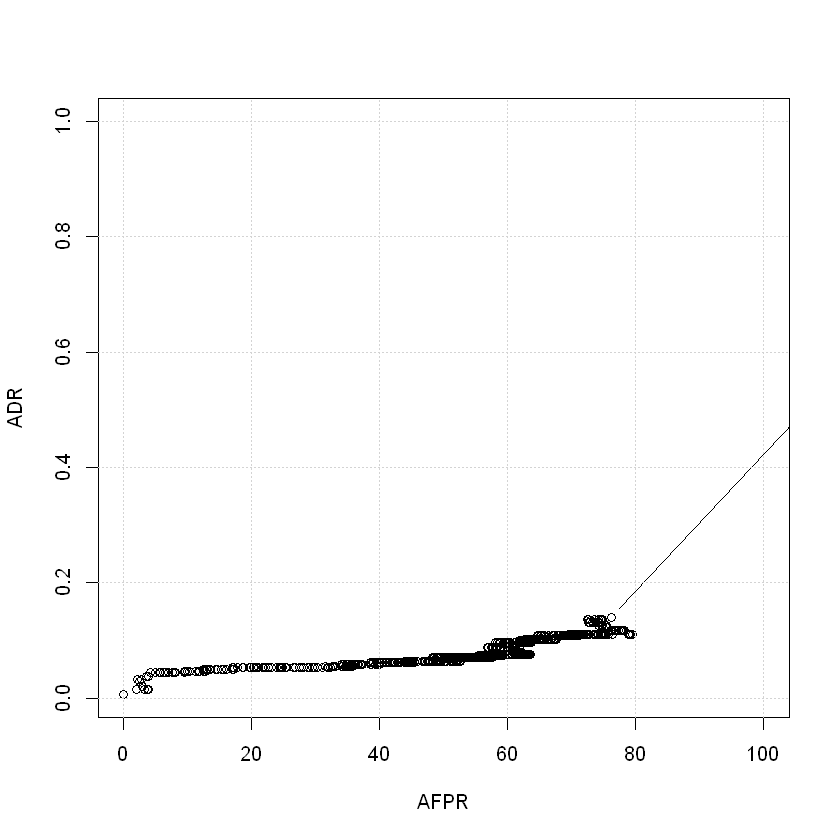

In [39]:
# Fraud account level metrics plots. 

## ADR -- Fraud account detection rate
plot(perf[, 9], perf[, 1], type = 'b', xlab = 'AFPR', ylab = 'ADR', xlim = c(0, 100))
grid()
    

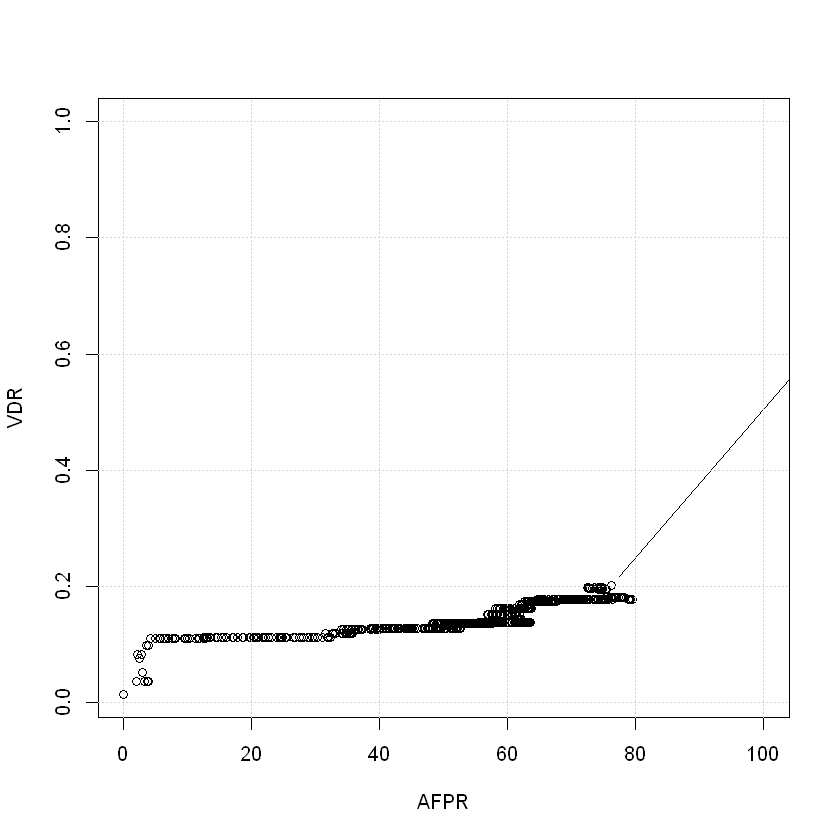

In [40]:
## VDR -- Value detection rate. The percentage of values saved.
plot(perf[, 9], perf[, 5], type = 'b', xlab = 'AFPR', ylab = 'VDR', xlim = c(0, 100))
grid()

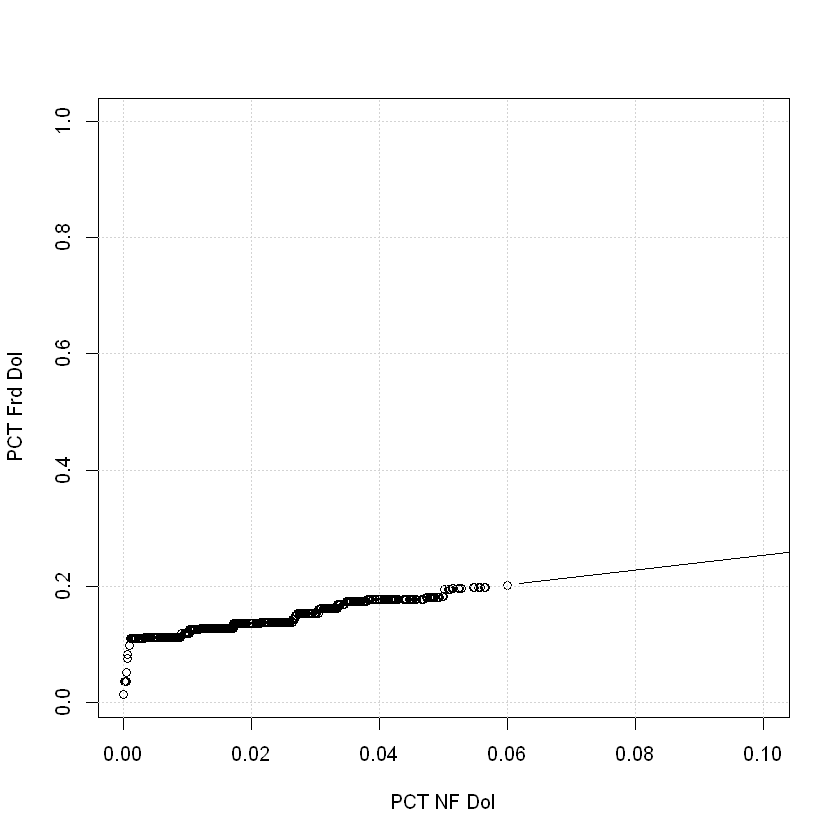

In [41]:
## Dollar weighted ROC
plot(perf[, 4], perf[, 3], type = 'b', xlab = 'PCT NF Dol', ylab = 'PCT Frd Dol', xlim = c(0, 0.1))
grid()

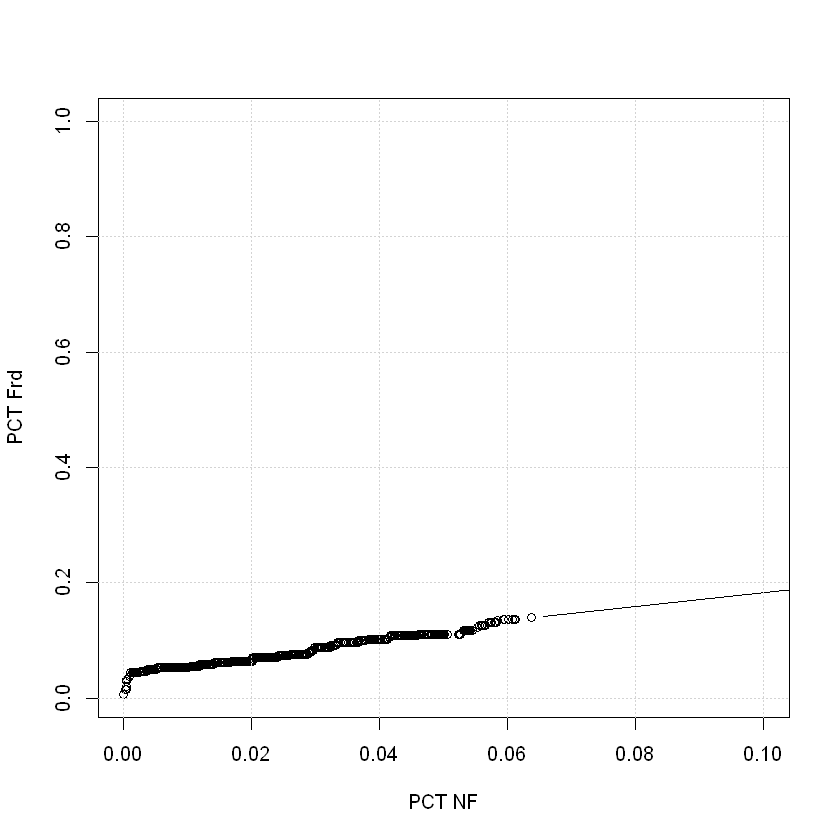

In [42]:
## ROC
plot(perf[, 8], perf[, 7], type = 'b', xlab ='PCT NF', ylab = 'PCT Frd', xlim = c(0, 0.1))
grid()

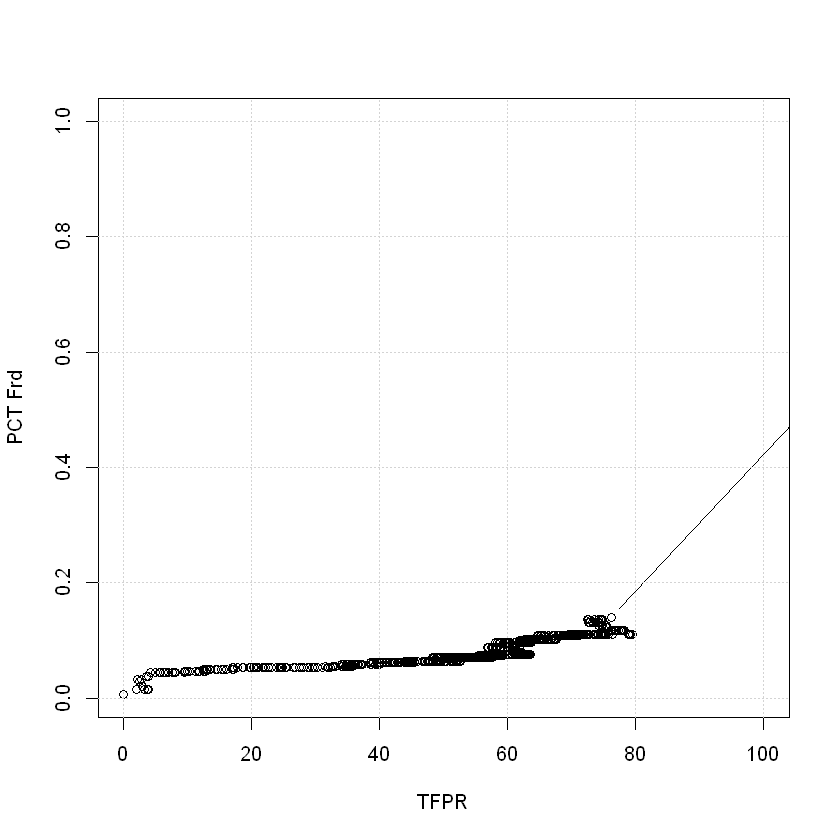

In [43]:
## TFPR vs TDR
plot(perf[, 10], perf[, 7], type = 'b', xlab ='TFPR', ylab = 'PCT Frd', xlim = c(0, 100))
grid()

In [44]:
# Close the Obdc connection used for rxExecuteSQLddl functions.
rxClose(outOdbcDS)

Warning message in rxClose(outOdbcDS):
"The datasource is not open yet."

[1] TRUE